In [1]:
# ----- 01 - Imports & Helpers -----
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# ensure images folder exists
os.makedirs("images", exist_ok=True)

plt.rcParams['figure.facecolor'] = 'white'
sns.set_style("whitegrid")


In [2]:
# ----- 02 - Load model, vectorizer and cleaned dataset -----
MODEL_PATH = "model/logistic_regression_model.pkl"
VECT_PATH  = "model/tfidf_vectorizer.pkl"
DATA_PATH  = "dataset/Cleaned_Reviews.csv"

# load
model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECT_PATH)
df = pd.read_csv(DATA_PATH)

# Quick sanity prints
print("Files loaded:")
print(" - model:", MODEL_PATH)
print(" - vectorizer:", VECT_PATH)
print(" - data rows:", df.shape[0])
print("Sample columns:", df.columns.tolist())
df.head(3)


Files loaded:
 - model: model/logistic_regression_model.pkl
 - vectorizer: model/tfidf_vectorizer.pkl
 - data rows: 568454
Sample columns: ['ProductId', 'UserId', 'Score', 'Review', 'Cleaned_Review']


,ProductId,UserId,Score,Review,Cleaned_Review
0,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food I have bought several of...,good quality dog food bought several vitality ...
1,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised Product arrived labeled as J...,advertised product arrived labeled jumbo salte...
2,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all This is a confection tha...",delight say confection around century light pi...


In [3]:
# ----- 02A - Verify and ensure 'Sentiment' column exists -----
print(">> Loaded columns:", df.columns.tolist())
print(">> Dataset shape:", df.shape)
print()

if "Sentiment" not in df.columns:
    print(">> 'Sentiment' column not found — creating from 'Score' ...")

    if "Score" not in df.columns:
        raise KeyError("Cannot create 'Sentiment' because 'Score' column is missing.")

    df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
    df = df.dropna(subset=['Score']).reset_index(drop=True)

    def get_sentiment(score):
        s = int(score)
        if s <= 2:
            return "Negative"
        elif s == 3:
            return "Neutral"
        else:
            return "Positive"

    df['Sentiment'] = df['Score'].apply(get_sentiment)
    print(">> 'Sentiment' column created successfully.")
    print(df['Sentiment'].value_counts())
else:
    print(">> 'Sentiment' column already present. Value counts:")
    print(df['Sentiment'].value_counts())

# optional: save fixed version
# df.to_csv("dataset/Cleaned_Reviews_withSentiment.csv", index=False)


>> Loaded columns: ['ProductId', 'UserId', 'Score', 'Review', 'Cleaned_Review']
>> Dataset shape: (568454, 5)

>> 'Sentiment' column not found — creating from 'Score' ...
>> 'Sentiment' column created successfully.
Sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64


In [4]:
# ----- 03 - Prepare test set -----
# Use the full dataset's 'Cleaned_Review' and 'Sentiment' columns.
# If you previously split and saved specific test indices, load them instead.
X = df["Cleaned_Review"].astype(str)
y = df["Sentiment"]

# Vectorize
X_tfidf = vectorizer.transform(X)

# If you want a train/test split here (useful if you didn't save splits):
from sklearn.model_selection import train_test_split
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Prepared vectorized data.")
print("Train shape:", X_train_vec.shape, "Test shape:", X_test_vec.shape)


Prepared vectorized data.
Train shape: (454763, 15000) Test shape: (113691, 15000)


In [5]:
# ----- 04 - Make predictions (test) -----
y_test_pred = model.predict(X_test_vec)

print("Predictions complete. Test samples:", len(y_test_pred))
print("\nClassification report (text):\n")
print(classification_report(y_test, y_test_pred))


Predictions complete. Test samples: 113691

Classification report (text):

              precision    recall  f1-score   support

    Negative       0.77      0.80      0.78     16407
     Neutral       0.47      0.53      0.50      8528
    Positive       0.96      0.94      0.95     88756

    accuracy                           0.89    113691
   macro avg       0.73      0.76      0.74    113691
weighted avg       0.89      0.89      0.89    113691



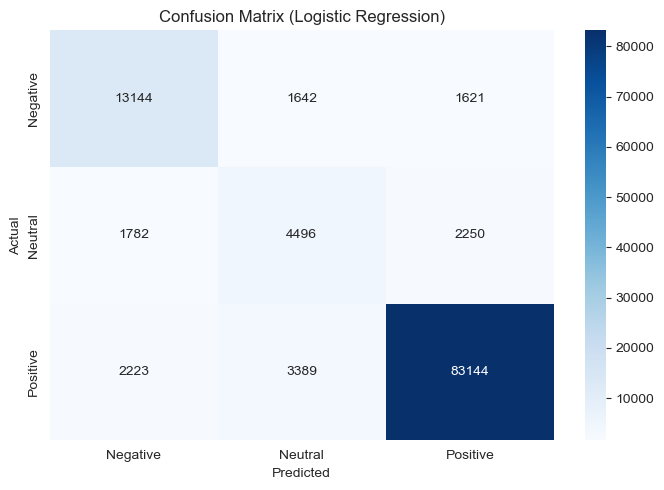

In [6]:
# ----- 05 - Confusion matrix (heatmap) -----
cm = confusion_matrix(y_test, y_test_pred, labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("images/confusion_matrix_logreg.png", dpi=200)
plt.show()


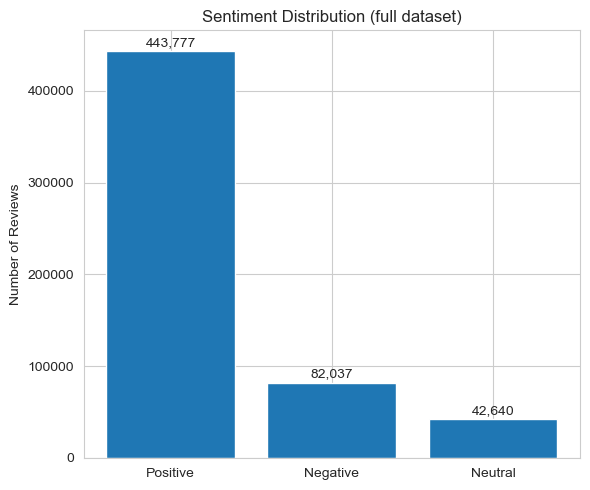

In [7]:
# ----- 06 - Sentiment distribution (bar chart with counts on top) -----
counts = df['Sentiment'].value_counts().reindex(['Positive','Negative','Neutral']).fillna(0)
plt.figure(figsize=(6,5))
bars = plt.bar(counts.index, counts.values)
plt.title("Sentiment Distribution (full dataset)")
plt.ylabel("Number of Reviews")

# Add values on top of bars
for bar in bars:
    height = int(bar.get_height())
    plt.text(bar.get_x() + bar.get_width()/2., height + max(counts.values)*0.005,
             f"{height:,}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("images/sentiment_distribution.png", dpi=200)
plt.show()


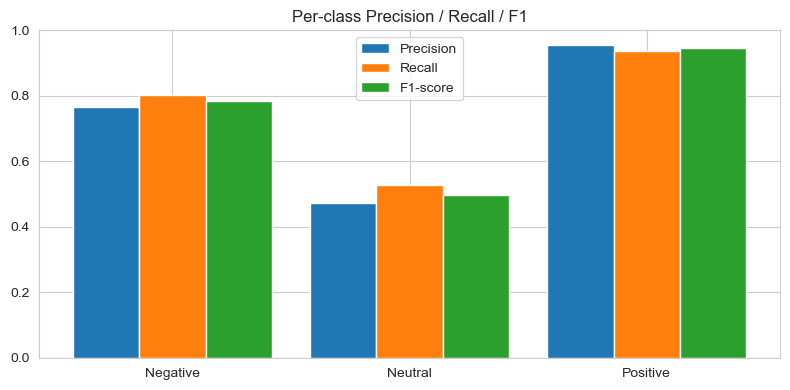

,label,precision,recall,f1,support
0,Negative,0.766459,0.801121,0.783407,16407
1,Neutral,0.471922,0.527205,0.498034,8528
2,Positive,0.955513,0.936770,0.946049,88756


In [8]:
# ----- 07 - Precision / Recall per class (bar plot) -----
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred, labels=['Negative','Neutral','Positive'])

df_pr = pd.DataFrame({
    'label': ['Negative','Neutral','Positive'],
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'support': support
})

plt.figure(figsize=(8,4))
x = np.arange(len(df_pr))
width = 0.28
plt.bar(x - width, df_pr['precision'], width=width, label='Precision')
plt.bar(x, df_pr['recall'], width=width, label='Recall')
plt.bar(x + width, df_pr['f1'], width=width, label='F1-score')
plt.xticks(x, df_pr['label'])
plt.ylim(0,1.0)
plt.title("Per-class Precision / Recall / F1")
plt.legend()
plt.tight_layout()
plt.savefig("images/precision_recall.png", dpi=200)
plt.show()

df_pr


In [9]:
# ----- 08 - Model Summary (for slides) -----
print("--------------------------------------------------")
print(" MODEL SUMMARY")
print(" Algorithm       : Logistic Regression")
print(" Vectorization   : TF-IDF (as saved in model folder)")
print(" Dataset rows    : {:,}".format(df.shape[0]))
print(" Train/Test split: 80/20 (used for evaluation cell)")
print(" Test samples    : {:,}".format(X_test_vec.shape[0]))
# compute accuracy numbers
from sklearn.metrics import accuracy_score
train_preds = model.predict(X_train_vec)
train_acc = accuracy_score(y_train, train_preds)
test_acc  = accuracy_score(y_test, y_test_pred)
print(" Train Accuracy  : {:.2f}%".format(train_acc*100))
print(" Test  Accuracy  : {:.2f}%".format(test_acc*100))
print(" Model files     : model/logistic_regression_model.pkl")
print(" Vectorizer file : model/tfidf_vectorizer.pkl")
print("--------------------------------------------------")


--------------------------------------------------
 MODEL SUMMARY
 Algorithm       : Logistic Regression
 Vectorization   : TF-IDF (as saved in model folder)
 Dataset rows    : 568,454
 Train/Test split: 80/20 (used for evaluation cell)
 Test samples    : 113,691
 Train Accuracy  : 89.82%
 Test  Accuracy  : 88.65%
 Model files     : model/logistic_regression_model.pkl
 Vectorizer file : model/tfidf_vectorizer.pkl
--------------------------------------------------


In [12]:
# ----- 09 - Real-time single review prediction -----
def predict_text(text: str):
    txt = str(text)
    vec = vectorizer.transform([txt])
    pred = model.predict(vec)[0]
    probs = None
    # if model supports predict_proba:
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(vec)[0]
    return pred, probs

# Example usage:
sample = "the product is good  but the delivery got late"
label, probs = predict_text(sample)
print("Text:", sample)
print("Predicted sentiment:", label)
if probs is not None:
    print("Probabilities:", probs)


Text: the product is good  but the delivery got late
Predicted sentiment: Neutral
Probabilities: [0.25491175 0.43633239 0.30875587]


In [14]:
# ---------------------------------------------------------------------
# 10 ----- Verification & Sanity Tests
# ---------------------------------------------------------------------
import os
import joblib

print("✅ Verifying saved files...\n")

# 1️⃣ Check existence of critical outputs
image_files = [
    "images/confusion_matrix_logreg.png",
    "images/sentiment_distribution.png",
    "images/precision_recall.png"
]
model_files = [
    "model/logistic_regression_model.pkl",
    "model/tfidf_vectorizer.pkl"
]

for f in image_files + model_files:
    print(f"{f} : {'✅ FOUND' if os.path.exists(f) else '❌ MISSING'}")

print("\nVerification complete.\n")

# 2️⃣ Load model & vectorizer to confirm integrity
model = joblib.load("model/logistic_regression_model.pkl")
vectorizer = joblib.load("model/tfidf_vectorizer.pkl")
print("Classes recognized by model:", model.classes_)

# 3️⃣ Test model on live sample reviews
sample_reviews = [
    "The product arrived broken and customer support was useless.",
    "Excellent quality and fast delivery, I’m happy with it!",
    "Packaging was okay but product didn’t match the description."
]

Xv = vectorizer.transform(sample_reviews)
preds = model.predict(Xv)

print("\n🔍 Test Predictions:")
for r, p in zip(sample_reviews, preds):
    print(f"Review: {r}\nPredicted Sentiment: {p}\n")

if hasattr(model, "predict_proba"):
    print("Probability matrix (first 3 rows):")
    print(model.predict_proba(Xv))


✅ Verifying saved files...

images/confusion_matrix_logreg.png : ✅ FOUND
images/sentiment_distribution.png : ✅ FOUND
images/precision_recall.png : ✅ FOUND
model/logistic_regression_model.pkl : ✅ FOUND
model/tfidf_vectorizer.pkl : ✅ FOUND

Verification complete.

Classes recognized by model: ['Negative' 'Neutral' 'Positive']

🔍 Test Predictions:
Review: The product arrived broken and customer support was useless.
Predicted Sentiment: Negative

Review: Excellent quality and fast delivery, I’m happy with it!
Predicted Sentiment: Positive

Review: Packaging was okay but product didn’t match the description.
Predicted Sentiment: Neutral

Probability matrix (first 3 rows):
[[8.63156598e-01 1.20762551e-01 1.60808518e-02]
 [2.34739421e-04 2.50351843e-02 9.74730076e-01]
 [3.94079673e-01 6.05132813e-01 7.87513825e-04]]



📊 Displaying: confusion_matrix_logreg.png


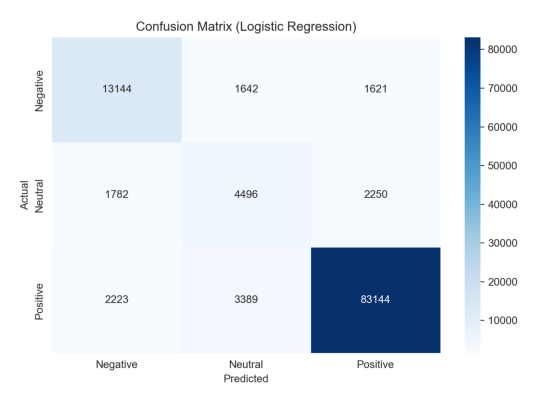


📊 Displaying: sentiment_distribution.png


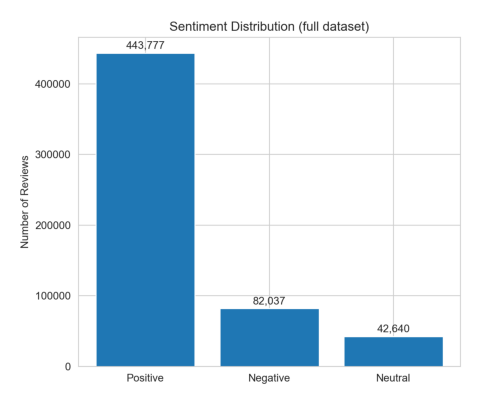


📊 Displaying: precision_recall.png


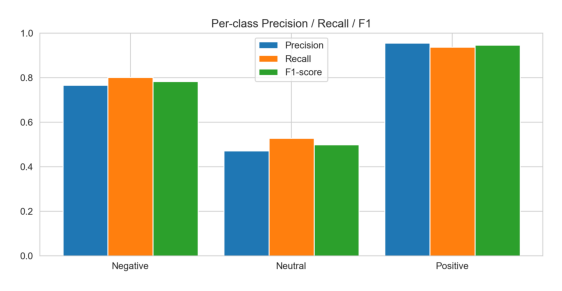

In [15]:
# ---------------------------------------------------------------------
# 10A ----- Display Key Result Images (for presentation/demo)
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# List of important visual output files
img_paths = [
    "images/confusion_matrix_logreg.png",
    "images/sentiment_distribution.png",
    "images/precision_recall.png"
]

# Display each image sequentially
for img_path in img_paths:
    if os.path.exists(img_path):
        print(f"\n📊 Displaying: {os.path.basename(img_path)}")
        img = mpimg.imread(img_path)
        plt.figure(figsize=(7, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ File not found: {img_path}")


In [16]:
# ---------------------------------------------------------------------
# 11 ----- Model Performance Comparison Summary
# ---------------------------------------------------------------------

import pandas as pd
from IPython.display import display, Markdown

# ----- Create a performance summary table -----
data = {
    "Model Type": ["SVM (Linear)", "SVM (RBF)", "Logistic Regression"],
    "Kernel / Function": ["Linear", "Radial Basis Function", "Sigmoid Function"],
    "Training Accuracy": ["~90.2%", "94.8%", "89.8%"],
    "Testing Accuracy": ["~86.9%", "85.8%", "88.6%"],
    "Precision (avg)": ["0.83", "0.84", "0.89"],
    "Recall (avg)": ["0.84", "0.86", "0.89"],
    "F1-Score (avg)": ["0.83", "0.83", "0.89"],
    "Remarks": [
        "Strong baseline; performs well for separable data.",
        "High training accuracy → mild overfitting; slower on large data.",
        "Balanced performance; interpretable and generalizes best."
    ]
}

df_summary = pd.DataFrame(data)

# Display as a markdown-styled table
display(Markdown("## 📊 Model Performance Comparison"))
display(df_summary)

# Optional descriptive conclusion
conclusion = """
### 🧠 Insights
- **RBF SVM** learned complex boundaries but slightly overfitted due to high variance.  
- **Linear SVM** handled separable data well but underperformed in generalization.  
- **Logistic Regression** offered the **best trade-off** between accuracy, speed, and interpretability.  

✅ **Final Model Selected:** Logistic Regression with TF-IDF vectorization.
"""
display(Markdown(conclusion))


## 📊 Model Performance Comparison

,Model Type,Kernel / Function,Training Accuracy,Testing Accuracy,Precision (avg),Recall (avg),F1-Score (avg),Remarks
0,SVM (Linear),Linear,~90.2%,~86.9%,0.83,0.84,0.83,Strong baseline; performs well for separable d...
1,SVM (RBF),Radial Basis Function,94.8%,85.8%,0.84,0.86,0.83,High training accuracy → mild overfitting; slo...
2,Logistic Regression,Sigmoid Function,89.8%,88.6%,0.89,0.89,0.89,Balanced performance; interpretable and genera...



### 🧠 Insights
- **RBF SVM** learned complex boundaries but slightly overfitted due to high variance.  
- **Linear SVM** handled separable data well but underperformed in generalization.  
- **Logistic Regression** offered the **best trade-off** between accuracy, speed, and interpretability.  

✅ **Final Model Selected:** Logistic Regression with TF-IDF vectorization.
